In [1]:
%matplotlib inline

import os
import json
import matplotlib
import numpy as np
import scipy.stats
import pandas as pd
from collections import Counter

In [2]:
epsList = ['0', '0.5', '1', '1.5', '2', '3', '4']
# TODO: CHANGE THIS AS WE ANALYZE MORE SAMPLES
numSamples = 100
correctList = ['Valid Eps 0 Classification']

df = pd.DataFrame(index=[str(i) for i in range(numSamples)])
for eps in epsList:
    jsonPath = "results/sample%d/jl_eps_%s_600_amortized.json" % (numSamples, eps)
    dfNew = pd.read_json(path_or_buf=jsonPath, orient='columns')
    df = df.join(other=dfNew, how='right')
    
    # Add a column to indicate which samples were classified correctly
    prefix = 'Eps %s' % eps
    colList = ['Adv%d %s Classification' % (i, prefix) for i in range(9)]
    df['%s Correct Classification' % prefix] = 45 - df[colList].sum(axis=1)
    df['%s Correct' % prefix] = (df['%s Correct Classification' % prefix] == df['Valid %s Classification' % prefix])
    correctList.append('%s Correct' % prefix)
df[correctList]

,Valid Eps 0 Classification,Eps 0 Correct,Eps 0.5 Correct,Eps 1 Correct,Eps 1.5 Correct,Eps 2 Correct,Eps 3 Correct,Eps 4 Correct
0,7,True,True,True,True,True,False,True
1,1,False,False,False,False,False,False,False
10,5,False,False,False,False,False,False,False
11,5,False,False,False,False,False,False,False
12,7,False,False,True,False,False,False,True
13,7,False,False,False,False,False,True,False
14,1,True,True,True,True,True,True,True
15,1,False,False,False,False,False,False,False
16,7,False,False,False,False,False,False,False
17,7,True,True,True,True,True,False,True


In [3]:
# Only care about rows where both models classified correctly.
dfDict = {}
zeroCorrect = "Eps 0 Correct"
for eps in epsList:
    if eps is '0':
        continue
        
    epsCorrect = "Eps %s Correct" % eps
    dfDict[eps] = df[df[zeroCorrect] & df[epsCorrect]]

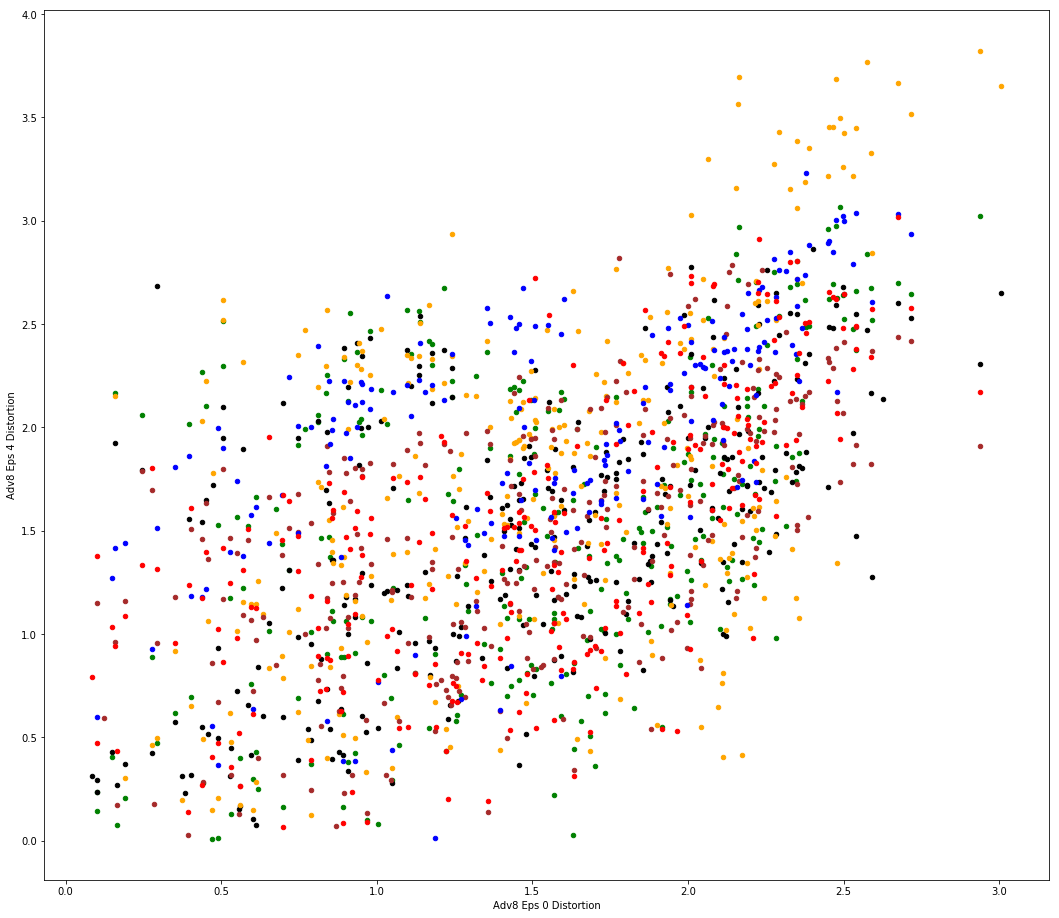

In [4]:
# TODO: Save plots separately, maybe plot regression lines as well?
ax = None
colorMap = {'0.5': 'green', '1': 'black', '1.5': 'orange', '2': 'brown', '3': 'blue', '4': 'red'}

for eps in dfDict:  
    for i in range(9):
        zeroLabel = "Adv%d Eps 0 Distortion" % i
        epsLabel = "Adv%d Eps %s Distortion" % (i, eps)
        
        if ax is None:
            ax = dfDict[eps].plot(kind='scatter', x=zeroLabel, y=epsLabel, c=colorMap[eps], figsize=(18, 16))
        else:
            dfDict[eps].plot(kind='scatter', x=zeroLabel, y=epsLabel, c=colorMap[eps], ax=ax, figsize=(18, 16))

In [6]:
# TODO: Plot the regression lines
slopeDict = {}
interceptDict = {}
for eps in dfDict:
    x = []
    y = []
    for i in range(9):
        xLabel = "Adv%d Eps 0 Distortion" % i
        yLabel = "Adv%d Eps %s Distortion" % (i, eps)
        
        x.extend(dfDict[eps][xLabel].values)
        y.extend(dfDict[eps][yLabel].values)
        
    reg = scipy.stats.linregress(x, y)
    slopeDict[eps] = reg[0]
    interceptDict[eps] = reg[1]
print(slopeDict)
print(interceptDict)

{'0.5': 0.5427881330127631, '1': 0.5763909471626059, '1.5': 0.6769568442695537, '2': 0.5708661316120217, '3': 0.5795710995228307, '4': 0.662324028147151}
{'0.5': 0.6986958862890236, '1': 0.6319538480332082, '1.5': 0.7288523800138258, '2': 0.6095451538721162, '3': 1.0734406502344316, '4': 0.4821390500156286}


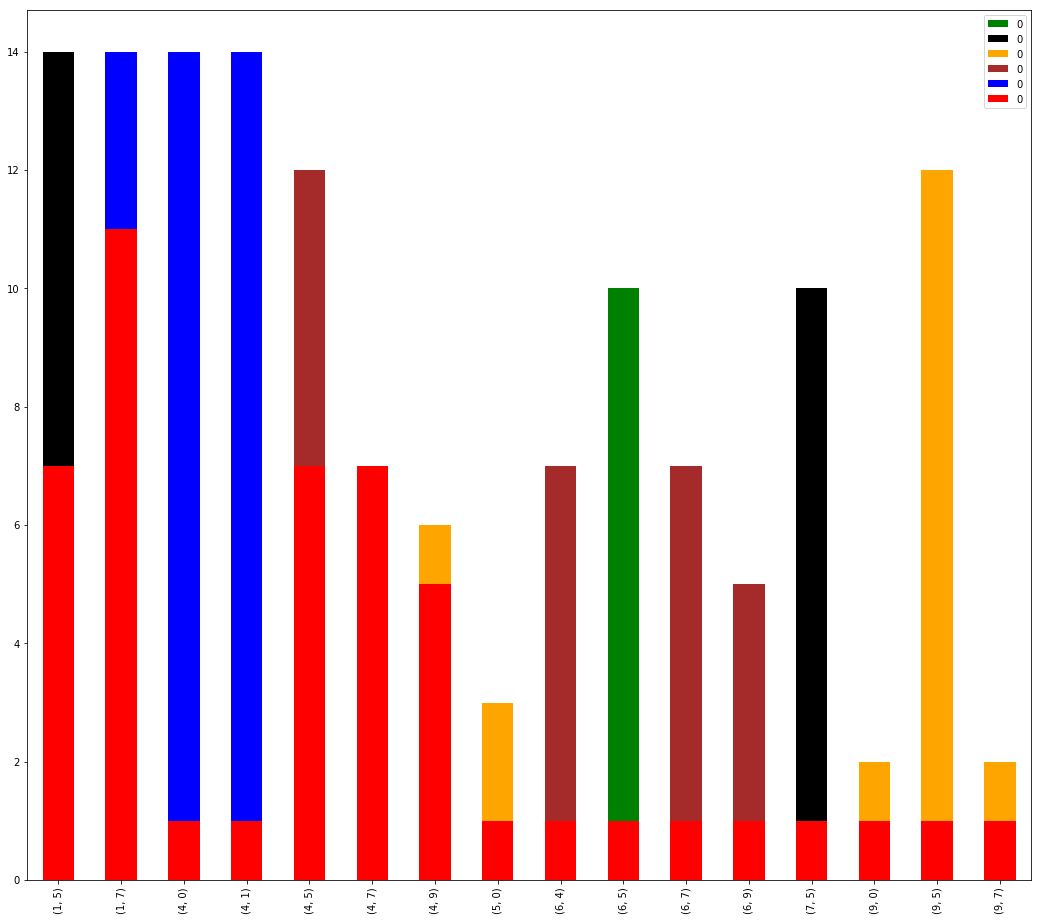

In [7]:
# When is DP much better than no DP?
dpBetterCorrect = {}
dpBetterAdv = {}
dpBetterDict = {}
dpBetterPairs = {}
dpHist = None

for eps in dfDict:
    if eps in ['0.1', '0.2']:
        continue
    
    dpBetterCorrect[eps] = []
    dpBetterAdv[eps] = []
    
    for i in range(9):
        zeroLabel = "Adv%d Eps 0 Distortion" % i
        epsLabel = "Adv%d Eps %s Distortion" % (i, eps)
        dpBetterDict[eps] = dfDict[eps][dfDict[eps][epsLabel] >= dfDict[eps][zeroLabel] * 1.5]
        
        dpBetterCorrect[eps].extend(dpBetterDict[eps]["Valid Eps %s Classification" % eps].values)
        dpBetterAdv[eps].extend(dpBetterDict[eps]["Adv%d Eps %s Classification" % (i, eps)].values)

for eps in dpBetterCorrect:
    dpBetterPairs[eps] = [(dpBetterCorrect[eps][i], dpBetterAdv[eps][i]) for i in range(len(dpBetterCorrect[eps]))]
    dpBetterPairs[eps].sort()
    
    dpBetterPairsDF = pd.DataFrame.from_dict(Counter(dpBetterPairs[eps]), orient='index')
    if dpBetterPairsDF.empty:
        continue
    
    if (dpHist is None):
        dpHist = dpBetterPairsDF.plot(kind='bar', color=colorMap[eps], figsize=(18,16))
    else:
        dpBetterPairsDF.plot(kind='bar', color=colorMap[eps], figsize=(18,16), ax=dpHist)
dpHist

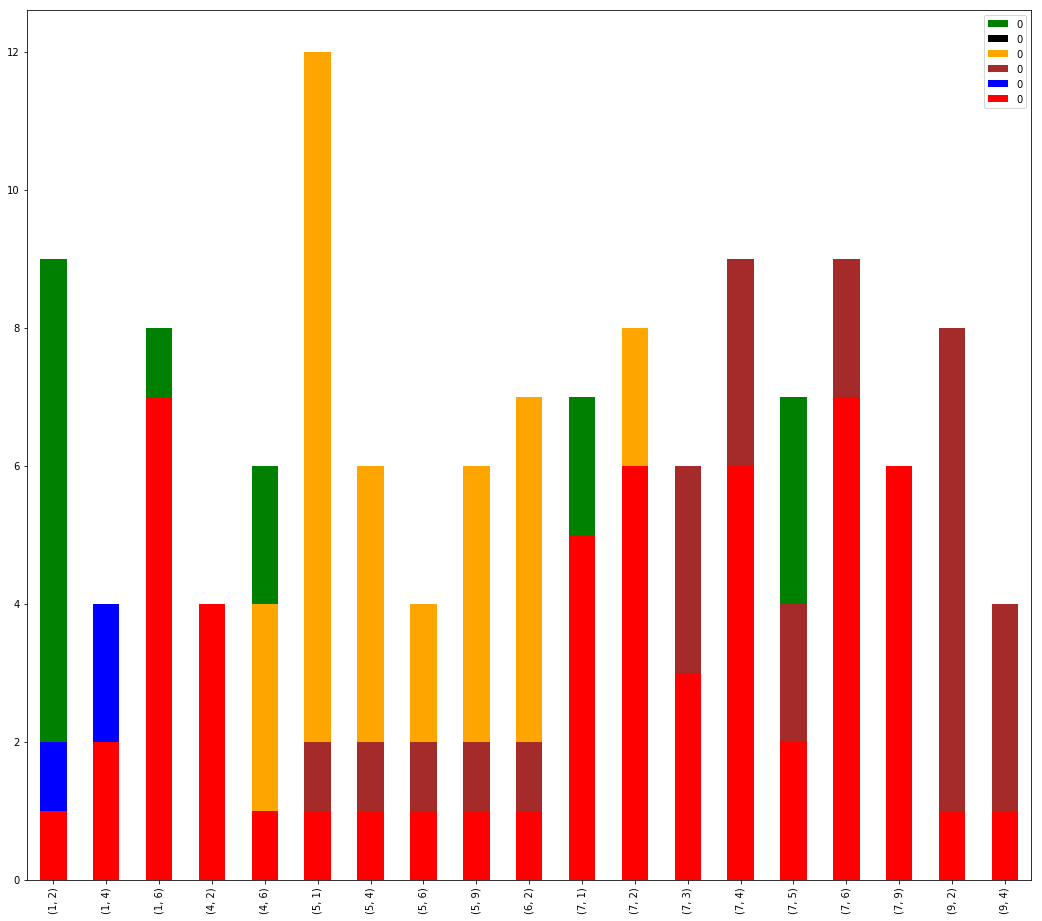

In [8]:
# When is no DP much better than DP?
noDPBetterCorrect = {}
noDPBetterAdv = {}
noDPBetterDict = {}
noDPBetterPairs = {}
noDPHist = None

for eps in dfDict:
    if eps in ['0.1', '0.2']:
        continue
    
    noDPBetterCorrect[eps] = []
    noDPBetterAdv[eps] = []
    
    for i in range(9):
        zeroLabel = "Adv%d Eps 0 Distortion" % i
        epsLabel = "Adv%d Eps %s Distortion" % (i, eps)
        noDPBetterDict[eps] = dfDict[eps][dfDict[eps][zeroLabel] >= dfDict[eps][epsLabel] * 1.5]
        
        noDPBetterCorrect[eps].extend(noDPBetterDict[eps]["Valid Eps %s Classification" % eps].values)
        noDPBetterAdv[eps].extend(noDPBetterDict[eps]["Adv%d Eps %s Classification" % (i, eps)].values)

for eps in noDPBetterCorrect:
    noDPBetterPairs[eps] = [(noDPBetterCorrect[eps][i], noDPBetterAdv[eps][i]) for i in range(len(noDPBetterCorrect[eps]))]
    noDPBetterPairs[eps].sort()
    
    noDPBetterPairsDF = pd.DataFrame.from_dict(Counter(noDPBetterPairs[eps]), orient='index')
    if noDPBetterPairsDF.empty:
        continue
    
    if (noDPHist is None):
        noDPHist = noDPBetterPairsDF.plot(kind='bar', color=colorMap[eps], figsize=(18,16))
    else:
        noDPBetterPairsDF.plot(kind='bar', color=colorMap[eps], figsize=(18,16), ax=noDPHist)
noDPHist